In [206]:
import pandas as pd
import time
import datetime
import glob as mod_glob
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re


# Analyse segment statistics

In [231]:
# Read meta-data for all segments
datadir = 'data/'
segfile = 'segments/segments.csv'

md = pd.read_csv(datadir + segfile)
md.drop(columns='Unnamed: 0', inplace=True)
#md.set_index('id', inplace=True)


rl_ = None

# Read usage records
ridelog_files = mod_glob.glob(datadir + 'ridelogs/' + r"*.json")
for rf in ridelog_files:
    print(rf)
    jdata = []
    with open(rf) as ridelog:
        for line in ridelog:
            jdata.append(json.loads(line))
    if(rl_ is None):
        rl_ = pd.DataFrame(jdata)
    else:
        rl_ = pd.concat([rl_, pd.DataFrame(jdata)], ignore_index=True)
rl_['date'] = pd.to_datetime(rl_['time_retrieved'], unit='s').dt.date

data/ridelogs/segments-20201124.json
data/ridelogs/202012.json
data/ridelogs/202011.json


In [232]:
# Get historical average user per day
c = 'created_at'
md[c] = pd.to_datetime(md[c])
c = 'time_retrieved'
md[c] = pd.to_datetime(md[c], utc=True)
md['hist_length'] = md['time_retrieved'] - md['created_at']
md['hist_length_days'] = md['hist_length'].apply(lambda x: x.days)
md['weekly_avg'] = 7*md['effort_count'] / md['hist_length_days']
#md.index = md.index.map(str)
md[['id', 'name', 'weekly_avg']]

,id,name,weekly_avg
0,3808938,קפוצינו,42.460460
1,1248017,העלייה מרון,29.435212
2,4267589,מה עכשיו טיפוס,46.550512
3,18952377,שימרי,53.400507
4,2481821,מעלה רמי,70.917339
5,7774409,fun in the forest,128.915908
6,8574425,החילזון נהיה עצלן,49.897025
7,17421855,ברמים בירידה,101.636459
8,4202076,פאמפ טראק ריש לקיש,49.958379
9,1717839,סוללים צפון מערבה,28.956835


In [209]:
# Add the distribution across days of the week

tf = pd.read_csv('data/trailforks.csv')
# fix string dates
tf['date_orig'] = tf['date']
tf['date'] = pd.to_datetime(tf['date'].apply(lambda s : re.sub('(.*[ap]m).*', '\\1', s)),
                          format='%b %d, %Y @ %I:%M%p', errors='raise')

tf['weekday'] = tf['date'].dt.weekday
wdist = tf['weekday'].value_counts(normalize=True)
wdist = pd.DataFrame(data = {'weekday_weight' : wdist, 'weekday' : wdist.index.values})

In [210]:
# Apply weekly distribution to per-trail usage
left = md
right=wdist
# cross join
md = left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1)
md['daily_avg'] = md['weekly_avg'] * md['weekday_weight']
md['id'] = md['id'].map(str)


In [227]:
mdmd = md[['id', 'name', 'weekday', 'daily_avg']]
#mdmd.query('id == "3808938"')
mdmd

,id,name,weekday,daily_avg
0,3808938,קפוצינו,3,12.810687
1,3808938,קפוצינו,4,11.168781
2,3808938,קפוצינו,5,6.701269
3,3808938,קפוצינו,1,4.925719
4,3808938,קפוצינו,0,2.443767
...,...,...,...,...
72,17443790,Last Climb Carmel Cup,5,20.099278
73,17443790,Last Climb Carmel Cup,1,14.773829
74,17443790,Last Climb Carmel Cup,0,7.329651
75,17443790,Last Climb Carmel Cup,6,7.043337


In [212]:
# Tabulate ridelog data with date as index
rl2 = pd.pivot_table(rl_, index='date', values='effort_count', columns='segment_id')
rl2.set_index(pd.DatetimeIndex(rl2.index.values), inplace=True)

In [213]:
# resample daily, interpolate missing values, and diff against the previous day
daily = rl2.resample('1D').interpolate().fillna(method='bfill').diff()


In [214]:
daily

segment_id,1248017,1717839,17421855,17443790,18952377,2481821,3808938,4202076,4267589,7774409,8574425
2020-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-25,13.0,8.0,15.0,11.0,5.0,37.0,3.0,27.0,36.0,54.0,15.0
2020-11-26,0.0,0.0,0.0,2.0,0.0,-1.0,1.0,-1.0,1.0,-2.0,1.0
2020-11-27,1.0,1.0,6.0,16.0,0.0,27.0,20.0,0.0,4.0,16.0,4.0
2020-11-28,3.0,1.0,5.0,16.0,6.0,46.0,85.0,4.0,13.0,68.0,53.0
2020-11-29,4.0,0.0,3.0,1.0,6.0,26.0,12.0,6.0,9.0,36.0,3.0
2020-11-30,13.0,7.0,5.0,10.0,3.0,32.0,9.0,8.0,15.0,33.0,30.0
2020-12-01,7.0,2.0,13.0,5.0,0.0,16.0,24.0,12.0,17.0,22.0,0.0
2020-12-02,13.0,8.0,27.0,4.0,5.0,31.0,20.0,11.0,14.0,34.0,6.0
2020-12-03,5.0,12.0,18.0,10.0,2.0,18.0,5.0,9.0,10.0,23.0,9.0


In [217]:
# add the daily average in each segment

# first, convert the table to long format
all_segs = daily.columns
d2 = daily.reset_index()
d3 = d2.melt(id_vars = 'index', value_vars=all_segs)

d4 = d3.rename(columns = {'index' : 'date'})
d4['weekday'] = d4['date'].dt.weekday

#print(d4.dtypes)
#print(md.dtypes)
# tack on the daily averages
md_short = md[['id', 'weekday', 'daily_avg']]
d5 = d4.merge(md_short, how='left', left_on=['segment_id', 'weekday'], right_on=['id','weekday'])

d5

,date,segment_id,value,weekday,id,daily_avg
0,2020-11-24,1248017,NaN,1,1248017,3.414696
1,2020-11-25,1248017,13.0,2,1248017,1.429408
2,2020-11-26,1248017,0.0,3,1248017,8.880857
3,2020-11-27,1248017,1.0,4,1248017,7.742625
4,2020-11-28,1248017,3.0,5,1248017,4.645575
...,...,...,...,...,...,...
105,2020-11-29,8574425,3.0,6,8574425,2.759593
106,2020-11-30,8574425,30.0,0,8574425,2.871771
107,2020-12-01,8574425,0.0,1,8574425,5.788414
108,2020-12-02,8574425,6.0,2,8574425,2.423057


In [222]:

# compute usage relative to the daily average
d5['relative_usage'] = d5['value'] / d5['daily_avg']

d6 = d5[['date', 'segment_id', 'relative_usage']].copy()


# re-tabulate
d7 = pd.pivot_table(d6, index='date', values='relative_usage', columns='segment_id')

#pd.to_datetime(d7.index.values).weekday
d8 = d7.clip(lower=0, upper=1)
d8

segment_id,1248017,1717839,17421855,17443790,18952377,2481821,3808938,4202076,4267589,7774409,8574425
date,,,,,,,,,,,
2020-11-25,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-11-26,0.000000,0.000000,0.000000,0.052052,0.000000,0.000000,0.078060,0.000000,0.071201,0.000000,0.066426
2020-11-27,0.129155,0.131289,0.224430,0.477629,0.000000,1.000000,1.000000,0.000000,0.326674,0.471837,0.304764
2020-11-28,0.645776,0.218815,0.311708,0.796048,0.711924,1.000000,1.000000,0.507317,1.000000,1.000000,1.000000
2020-11-29,1.000000,0.000000,0.533705,0.141978,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-11-30,1.000000,1.000000,0.854762,1.000000,0.976114,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-12-01,1.000000,0.595380,1.000000,0.338436,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2020-12-02,1.000000,1.000000,1.000000,0.646789,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-12-03,0.563009,1.000000,0.586996,0.260258,0.124136,0.841264,0.390299,0.597099,0.712013,0.591335,0.597833


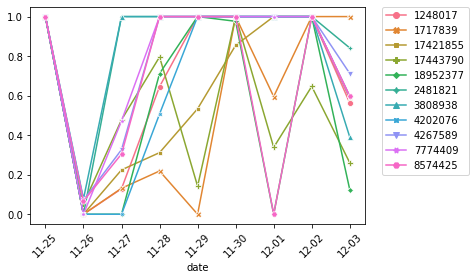

In [221]:
from matplotlib.dates import DateFormatter
sns.lineplot(data=d8, dashes=False, markers=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.gca().xaxis.set_major_formatter(DateFormatter("%m-%d"))
plt.xticks(rotation=45)
None

In [233]:
d8.mean(axis=1)

date
2020-11-25    1.000000
2020-11-26    0.024340
2020-11-27    0.369616
2020-11-28    0.744690
2020-11-29    0.788698
2020-11-30    0.984625
2020-12-01    0.721256
2020-12-02    0.967890
2020-12-03    0.569477
dtype: float64